# Modelo CNN con PyTorch para Clasificación de Imágenes Cerebrales

Este notebook implementa un modelo de Redes Neuronales Convolucionales (CNN) utilizando PyTorch para la clasificación de imágenes cerebrales, incluyendo visualizaciones avanzadas y funcionalidades de predicción.

In [1]:
# 1. Importar librerías
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# Bibliotecas para procesamiento de imágenes
import cv2
from PIL import Image

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)
import seaborn as sns

In [2]:
# 2. Comprobar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [3]:
# 3. Configuración de hiperparámetros
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
IMG_SIZE = 224

# 4. Transformaciones para preprocesamiento
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # si es RGB usa 3 valores
])

# 5. Cargar datos
DATA_DIR = '../data/Brain_Data_Organised'
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

In [4]:
# 6. Dividir en train y validación (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [5]:
# 7. Red neuronal
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 224),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(224, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)

In [6]:
# 8. Loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
# 9. Entrenamiento
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    train_loss /= len(train_dataset)
    train_accuracy = train_correct.double() / len(train_dataset)

    # Validación
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_accuracy = val_correct.double() / len(val_dataset)

    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    train_acc_values.append(train_accuracy.cpu())
    val_acc_values.append(val_accuracy.cpu())

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/10: Train Loss: 1.3379, Val Loss: 0.6562, Train Acc: 0.5715, Val Acc: 0.6188
Epoch 2/10: Train Loss: 0.5917, Val Loss: 0.5068, Train Acc: 0.6945, Val Acc: 0.7665
Epoch 3/10: Train Loss: 0.3830, Val Loss: 0.3361, Train Acc: 0.8285, Val Acc: 0.8603
Epoch 4/10: Train Loss: 0.2347, Val Loss: 0.2407, Train Acc: 0.9085, Val Acc: 0.8922
Epoch 5/10: Train Loss: 0.1561, Val Loss: 0.2056, Train Acc: 0.9435, Val Acc: 0.9122
Epoch 6/10: Train Loss: 0.1003, Val Loss: 0.1754, Train Acc: 0.9695, Val Acc: 0.9301
Epoch 7/10: Train Loss: 0.0681, Val Loss: 0.1378, Train Acc: 0.9795, Val Acc: 0.9341
Epoch 8/10: Train Loss: 0.0516, Val Loss: 0.1303, Train Acc: 0.9840, Val Acc: 0.9501
Epoch 9/10: Train Loss: 0.0425, Val Loss: 0.1369, Train Acc: 0.9875, Val Acc: 0.9561
Epoch 10/10: Train Loss: 0.0236, Val Loss: 0.1486, Train Acc: 0.9945, Val Acc: 0.9481


In [8]:
# 10. Guardar modelo
torch.save(model.state_dict(), "cnn_pytorch.pth")

## Evaluación del Modelo

Ahora evaluaremos el modelo en el conjunto de validación y calcularemos diversas métricas de rendimiento.

In [10]:
# Cargar el modelo guardado (opcional si ya está entrenado en esta sesión)
# model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)
# model.load_state_dict(torch.load("cnn_pytorch.pth", map_location=device))
model.eval()

# Evaluar el modelo en el conjunto de validación
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc_value = roc_auc_score(all_labels, np.array(all_probs)[:, 1])

print("\n--- Evaluación en conjunto de validación ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc_value:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


--- Evaluación en conjunto de validación ---
Accuracy:  0.9481
Precision: 0.9365
Recall:    0.9267
F1 Score:  0.9316
AUC:       0.9895

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       310
      Stroke       0.94      0.93      0.93       191

    accuracy                           0.95       501
   macro avg       0.95      0.94      0.94       501
weighted avg       0.95      0.95      0.95       501



## Visualización de Métricas de Entrenamiento

A continuación, generaremos visualizaciones más avanzadas para analizar el rendimiento del modelo.

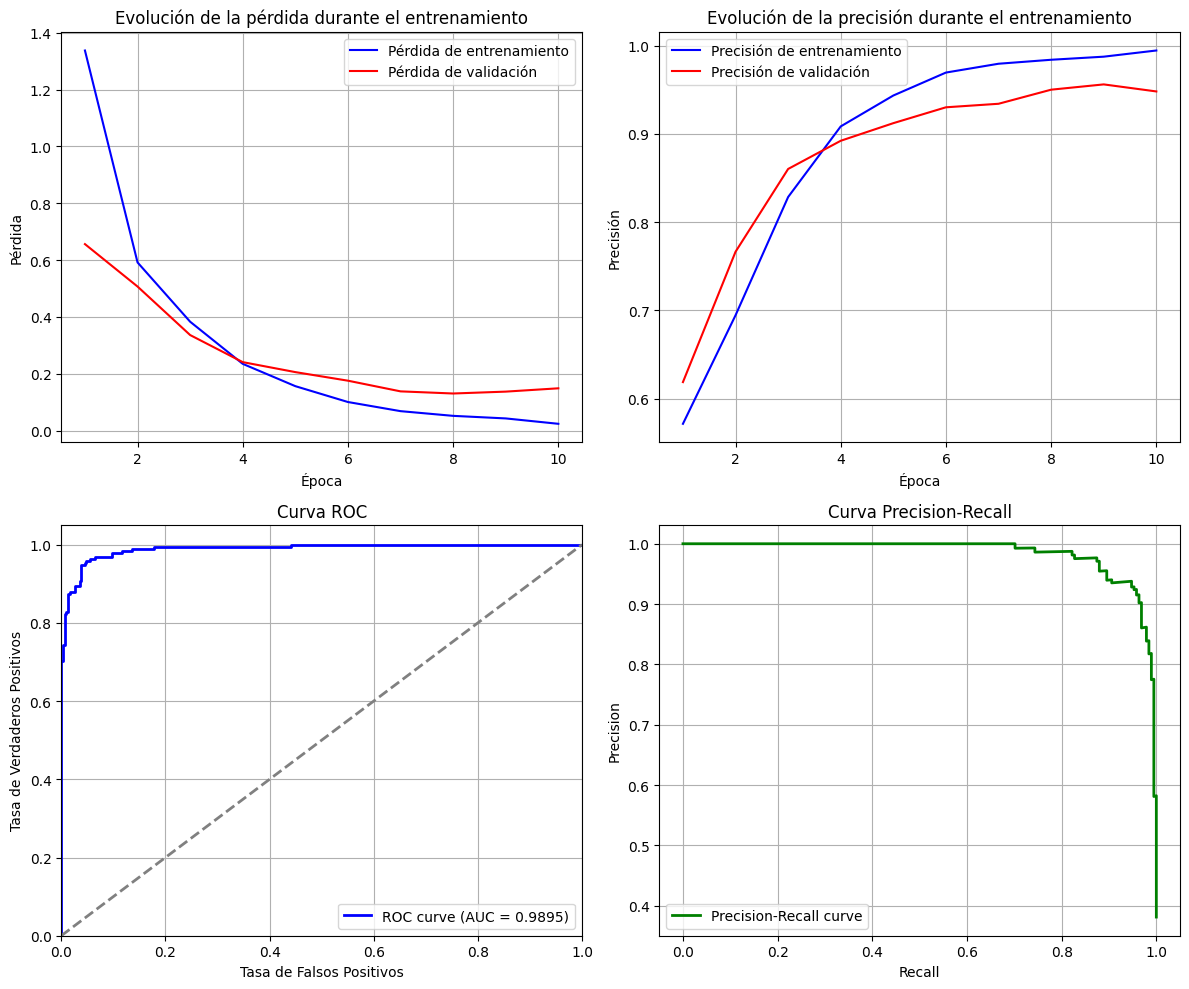

In [11]:
# Visualización de métricas avanzadas
plt.figure(figsize=(12, 10))

# Subplot para pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_values, 'b-', label="Pérdida de entrenamiento")
plt.plot(epochs, val_loss_values, 'r-', label="Pérdida de validación")
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Subplot para precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_values, 'b-', label="Precisión de entrenamiento")
plt.plot(epochs, val_acc_values, 'r-', label="Precisión de validación")
plt.title('Evolución de la precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Subplot para curva ROC
plt.subplot(2, 2, 3)
fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:, 1])
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)

# Subplot para curva Precision-Recall
plt.subplot(2, 2, 4)
precision_values, recall_values, _ = precision_recall_curve(all_labels, np.array(all_probs)[:, 1])
plt.plot(recall_values, precision_values, color='green', lw=2, label=f'Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
#plt.savefig('metricas_entrenamiento.png')
plt.show()

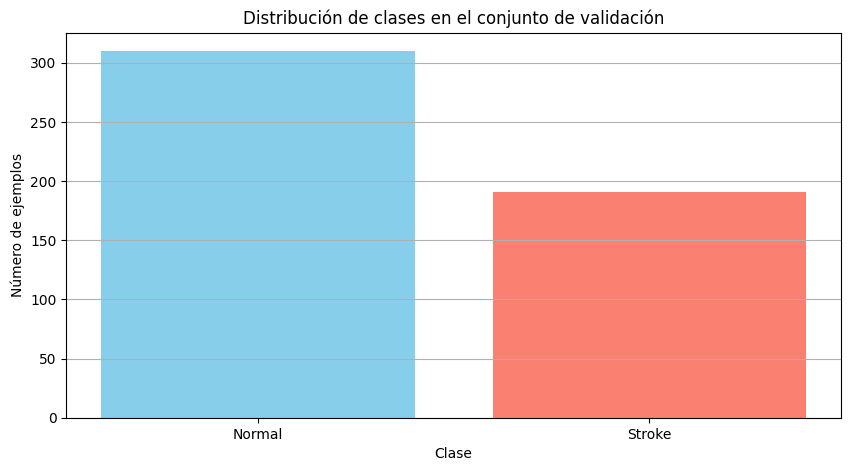

In [12]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 5))

# Contar ejemplos por clase
class_counts = np.bincount(all_labels)

# Crear gráfico de barras
plt.bar(full_dataset.classes, class_counts, color=['skyblue', 'salmon'])
plt.title('Distribución de clases en el conjunto de validación')
plt.xlabel('Clase')
plt.ylabel('Número de ejemplos')
plt.grid(axis='y')
#plt.savefig('distribucion_clases.png')
plt.show()

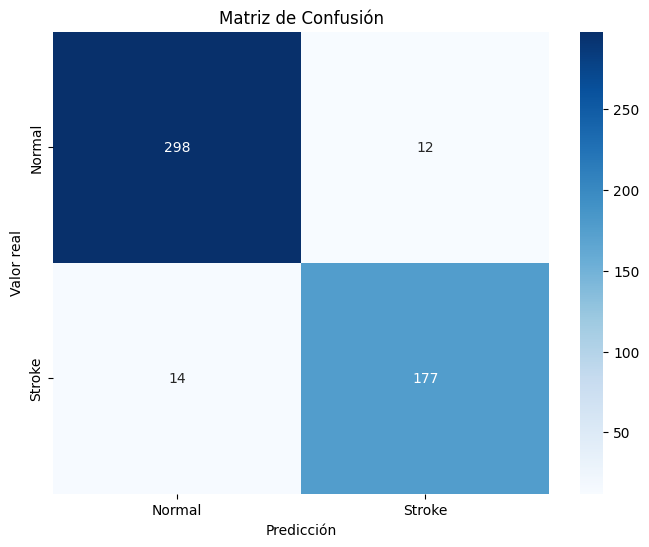

In [13]:
# Visualización de la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
#plt.savefig('matriz_confusion.png')
plt.show()

## Visualización de Ejemplos de Predicciones

Ahora visualizaremos algunos ejemplos de predicciones del modelo para entender mejor su comportamiento.

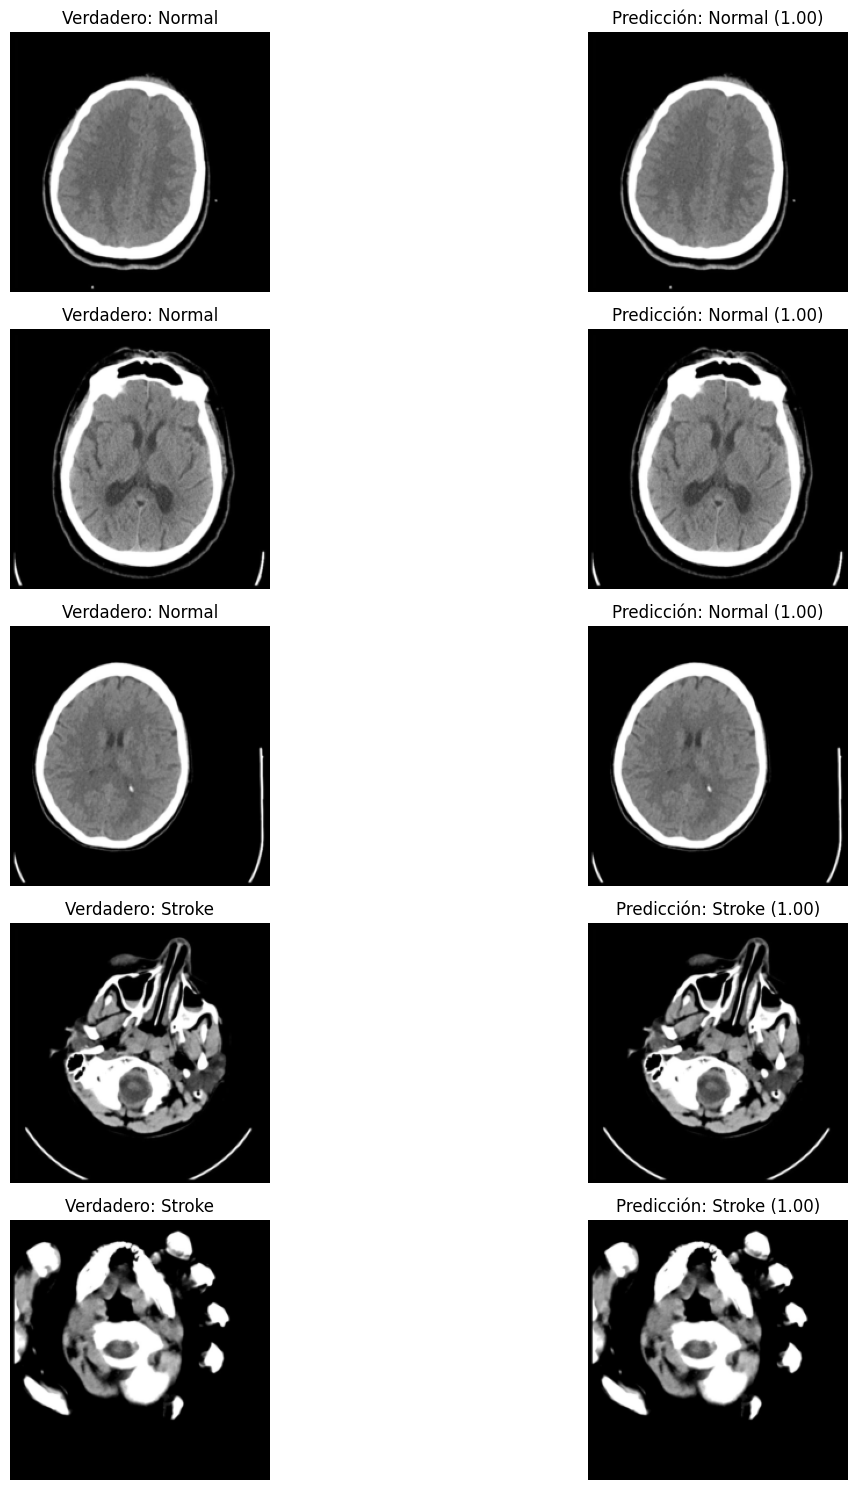

In [ ]:
# Función para visualizar ejemplos de predicciones
def visualize_predictions(model, dataloader, classes, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, num_images * 3))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    #fig.savefig('ejemplos_predicciones.png')
                    return
                
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far * 2 - 1)
                ax.set_title(f'Verdadero: {classes[labels[j]]}')
                plt.imshow(inputs[j].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                plt.axis('off')
                
                ax = plt.subplot(num_images, 2, images_so_far * 2)
                ax.set_title(f'Predicción: {classes[preds[j]]} ({torch.softmax(outputs[j], 0)[preds[j]].item():.2f})')
                plt.imshow(inputs[j].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                plt.axis('off')

# Visualizar algunas predicciones
visualize_predictions(model, val_loader, full_dataset.classes)
plt.tight_layout()
plt.show()

## Función para Realizar Predicciones con Nuevas Imágenes

A continuación, definimos una función para realizar predicciones con imágenes nuevas.

In [15]:
# Función para realizar predicciones con imágenes nuevas
def predict_image(image_path, model, transform, device, classes):
    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    
    # Aplicar transformaciones
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Realizar predicción
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        _, predicted = torch.max(outputs, 1)
    
    # Mostrar imagen y resultados
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicción: {classes[predicted.item()]}\nProbabilidad: {probs[predicted.item()]:.4f}')
    
    # Mostrar probabilidades para todas las clases
    for i, prob in enumerate(probs):
        print(f'Clase {classes[i]}: {prob.item():.4f}')
    
    #plt.savefig('prediccion_imagen.png')
    plt.show()
    
    return predicted.item(), probs.cpu().numpy()

Clase Normal: 0.9994
Clase Stroke: 0.0006


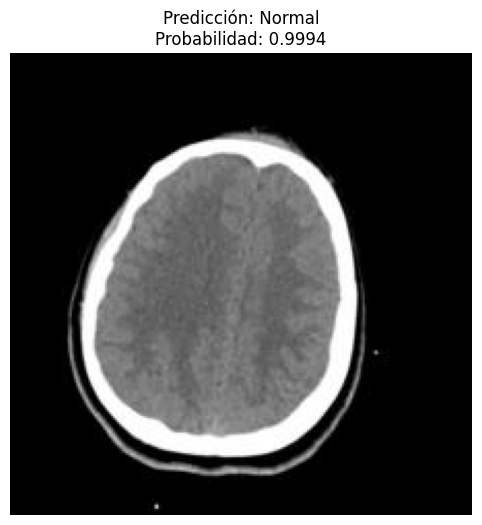

In [16]:
# Ejemplo de cómo usar una imagen del conjunto de validación para demostrar la predicción
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Seleccionar una imagen
img_idx = 0  # Puedes cambiar este índice para ver diferentes imágenes
img = images[img_idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
label = labels[img_idx].item()

# Guardar temporalmente la imagen para demostrar la predicción
temp_img_path = "temp_image.jpg"
plt.imsave(temp_img_path, img)

# Realizar predicción
predicted_class, probabilities = predict_image(temp_img_path, model, transform, device, full_dataset.classes)

# Eliminar la imagen temporal
os.remove(temp_img_path)

## Resumen del Modelo

Finalmente, mostramos un resumen de la arquitectura del modelo y sus características principales.

In [ ]:
# Compilador con SGD y regularización
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True, weight_decay=1e-4)


In [ ]:
# Evaluación de Overfitting
gap_loss = val_loss_values[-1] - train_loss_values[-1]
gap_acc = train_acc_values[-1] - val_acc_values[-1]

print("\n--- Evaluación de Overfitting ---")
print(f"Train Loss Final: {train_loss_values[-1]:.4f}")
print(f"Val Loss Final:   {val_loss_values[-1]:.4f}")
print(f"Train Acc Final:  {train_acc_values[-1]:.4f}")
print(f"Val Acc Final:    {val_acc_values[-1]:.4f}")

if gap_loss > 0.2 and gap_acc > 0.1:
    print("⚠️ Posible *overfitting* detectado. Revisa regularización, arquitectura o datos.")
else:
    print("✅ No se detectó *overfitting* significativo.")


In [17]:
# Mostrar un resumen de la arquitectura del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nResumen del modelo:")
print(f"Número total de parámetros entrenables: {count_parameters(model):,}")
print(f"Capas convolucionales: 2")
print(f"Capas fully connected: 2")
print(f"Función de activación: ReLU")
print(f"Regularización: Dropout (0.5)")
print(f"Optimizador: Adam (lr={LEARNING_RATE})")
print(f"Función de pérdida: CrossEntropyLoss")

print("\nInstrucciones para usar el modelo guardado para predicciones:")
print("1. Carga el modelo con torch.load('cnn_pytorch.pth')")
print("2. Preprocesa la imagen con las mismas transformaciones usadas en el entrenamiento")
print("3. Pasa la imagen por el modelo y aplica softmax para obtener probabilidades")
print("4. La clase con mayor probabilidad es la predicción final")


Resumen del modelo:
Número total de parámetros entrenables: 44,977,762
Capas convolucionales: 2
Capas fully connected: 2
Función de activación: ReLU
Regularización: Dropout (0.5)
Optimizador: Adam (lr=0.001)
Función de pérdida: CrossEntropyLoss

Instrucciones para usar el modelo guardado para predicciones:
1. Carga el modelo con torch.load('cnn_pytorch.pth')
2. Preprocesa la imagen con las mismas transformaciones usadas en el entrenamiento
3. Pasa la imagen por el modelo y aplica softmax para obtener probabilidades
4. La clase con mayor probabilidad es la predicción final


## Conclusión

El modelo actual muestra un buen rendimiento, pero hay margen de mejora. Las modificaciones sugeridas en el optimizador, arquitectura, aumento de datos y regularización pueden ayudar a mejorar las métricas de rendimiento. Recomiendo implementar estos cambios de forma incremental, evaluando el impacto de cada modificación para determinar qué combinación ofrece los mejores resultados para este problema específico de clasificación de imágenes cerebrales.

La elección entre Adam y SGD con momentum dependerá de sus prioridades: si necesita una convergencia rápida, Adam puede ser preferible; si busca mejor generalización, SGD con momentum podría ser más adecuado. En cualquier caso, el aumento de datos y la regularización adecuada serán fundamentales para mejorar el rendimiento del modelo en este tipo de tarea médica.